[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jlfvindel/asignatura_SW_KG/blob/main/intro_graphs_networkx/grafos_networkx.ipynb)

# Resumen
Ejemplo de conversión de datos tabulares a un grafo:
+ **Datos -> Tabla**. Desde un objeto Json a un DataFrame
+ **Tabla -> Ternas**. Hacia una lista de relaciones atómicas `(nodo1, enlace, nodo2)`.
+ **Ternas -> Grafo**. Hacia un grafo NetworkxY, con facilidades de análisis y visualización

# Inicialización del cuaderno
Colapse la sección para ejecutar todas sus celdas en un solo paso. O depliege para inspeccionarlas y ejecutarlas individualmente.

## Paquetes: instalación e importación

In [1]:
#Comente %%capture para ver informes del proceso
%%capture
!pip install networkx
!apt install graphviz graphviz-dev
!pip install pygraphviz
!pip install graphviz
!pip install pyvis


In [2]:
%%capture
# Datos json -> dataframe
import json
import pandas as pd

# Generación de grafos
import networkx as nx

# Visualización de grafos
import matplotlib.pyplot as plt
import pygraphviz as pgv
import graphviz as gv

from pyvis.network import Network
from IPython.display import display, HTML

## Funciones: datos json -> tabla -> tuplas

In [3]:
# DATOS. Ejemplo simplificado. En este caso, como lista de diccionarios. 
# Nombres como identificadores. Datos relacionales. Juan tiene dos registros.
datos_ej0 = [ 
    {'nombre':'Marcos', 'año_nacimiento':'1962', 'lugar_nacimiento':'Salamanca', 'tiene_madre':'Belén', 'tiene_padre':'Ángel'},
    {'nombre':'Arturo', 'año_nacimiento':'1966', 'tiene_madre':'Belén', 'tiene_padre':'Ángel'},
    {'nombre':'Pedro', 'año_nacimiento':'1979', 'lugar_nacimiento':'Badajoz', 'tiene_madre':'Inés', 'tiene_padre':'Pablo'},
    {'nombre':'Luis', 'año_nacimiento':'1984', 'lugar_nacimiento':'Madrid', 'tiene_madre':'Isabel', 'tiene_padre':'Jorge'},
    {'nombre':'Ana', 'año_nacimiento':'1982', 'lugar_nacimiento':'Madrid', 'tiene_madre':'Isabel', 'tiene_padre':'Jorge'},
    {'nombre':'Sonia', 'lugar_nacimiento':'Valencia', 'tiene_madre':'María', 'tiene_padre':'Fernando'},
    {'nombre':'Begoña', 'año_nacimiento':'2010', 'lugar_nacimiento':'Madrid', 'tiene_madre':'Sonia', 'tiene_padre':'Pedro'},
    {'nombre':'Marta', 'año_nacimiento':'2015', 'lugar_nacimiento':'Soria', 'tiene_madre':'Ana', 'tiene_padre':'Arturo'},
    {'nombre':'Juan', 'año_nacimiento':'2020', 'lugar_nacimiento':'Teruel', 'tiene_madre':'Ana'},
    {'nombre':'Juan', 'lugar_nacimiento':'Soria', 'tiene_padre':'Pedro'}]

datos = datos_ej0

# Impresión de datos, para este ejemplo 
def imprime_datos(datos):
    print(json.dumps(datos, indent=2,  ensure_ascii=False))

# TABLA. DataFrame. En este caso, datos con estructura tabular, quizá con celdas vacías y con filas repetidas.
# Para otros formatos de datos: pd.DataFrame.from_(dict|records), pd.read_(csv|xml|json), pd.json_normalize ...
def datos_a_tabla(datos):
    df = pd.DataFrame.from_records(datos_ej0)
    return df

def imprime_tabla(df):
    display(df)

# TUPLAS: lista de 3 tuplas.     
def tabla_a_tuplas3(df,col_idx = 0):
    '''
    Dataframe a 3tuplas (sujeto_celda_fila_X, cabecera_columna_Y, valor_celda_X_Y)
    col_idx=N si los sujetos de la 3tupla no están en la columna 0 sino en la N
    '''
    columnas = df.columns.values.tolist()
    columna_idx = columnas[col_idx]
    columnas.remove(columna_idx)

    ternas = []
    for fila in df.index:
        for columna in columnas:
            sujeto_t = df[columna_idx][fila]
            predicado_t = columna
            objeto_t = df[columna][fila]
            if pd.notnull(objeto_t):
                terna = (sujeto_t, predicado_t, objeto_t)
                ternas.append(terna)
    return ternas

def imprime_tuplas3(tuplas3):
    display(tuplas3)

## Funciones: tuplas -> grafo (ver, analizar)

In [27]:
# GRAFO: creación
def tuplas3_a_grafo(tuplas3):
    G = nx.DiGraph()
    for tupla in tuplas3:
        #G.add_node(terna[0])
        #G.add_node(terna[2])
        G.add_edge(tupla[0], tupla[2], label=tupla[1])
    return G

def describe_grafo(G):
    print(f'Dirigido: {nx.is_directed(G)}')
    print(f'Número de nodos: {nx.number_of_nodes(G)}. Número de aristas: {nx.number_of_edges(G)}')
    print(f'Números de nodos con grado 0, 1, 2, ... respectivamente: {nx.degree_histogram(G)}')

# GRAFO: análisis
def predecesores_nodos(G,lista_nodos):
    '''Ej: lista_nodos = [n1,n2] -> [[n3,n4],[n5,n6,n7]] = sus predecesores respectivos.
       Se retorna como lista aplanada [n3,n4,n5,n6,n7]'''
    preds_respectivos = [list(G.predecessors(nodo)) for nodo in lista_nodos]
    preds_aplanada = [nodo for sublista in preds_respectivos for nodo in sublista]
    return preds_aplanada

def sucesores_nodos(G,lista_nodos):
    '''Ej: lista_nodos = [n1,n2] -> [[n3,n4],[n5,n6,n7]] = sus sucesores respectivos.
       Se retorna como lista aplanada [n3,n4,n5,n6,n7]'''
    sucs_respectivos = [list(G.successors(nodo)) for nodo in lista_nodos]
    sucs_aplanada = [nodo for sublista in sucs_respectivos for nodo in sublista]
    return sucs_aplanada

def subgrafo_nodos(G,lista_nodos):
    '''lista_nodos -> subgrafo de G con nodos lista_nodos, sus predecesores y sus sucesores. Y
       con los ejes entre ellos que existían en G'''
    fusionados_sin_repeticiones = set(lista_nodos + predecesores_nodos(G,lista_nodos) + sucesores_nodos(G,lista_nodos))
    nodos_en_subgrafo = list(fusionados_sin_repeticiones)
    subgrafo = nx.subgraph(G,nodos_en_subgrafo)
    return subgrafo

def nodos_grado_max(G):
    '''G -> [n1,...,nk], nodos con el grado máximo (grado_entrada + grado_salida en digrafos)'''
    histograma_grados = nx.degree_histogram(G)
    grado_max = len(histograma_grados) - 1
    lista_nodos_max = [nodo for nodo, grado in nx.degree(G) if grado == grado_max]
    return lista_nodos_max

# GRAFO: visualización
def visualiza_grafo_matplotlib(G):
    # Admite muchas otras configuraciones
    nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=True)
    
def visualiza_grafo_graphviz(G):
    '''grafo g de networkx -> grafo A de pygraphviz, con texto del grafo en formato .dot en A.string()
       se prefiere usar finalmente el renderizado del paquete graphviz, que lee el string de pygraphviz'''
    A = nx.nx_agraph.to_agraph(G)
    return gv.Source(A.string(),format="svg")

def visualiza_grafo_pyvis(G,nombre_resultado="grafo_pyvis.html"):
    pyvis_g = Network(notebook=True, cdn_resources="remote")
    pyvis_g.from_nx(G)
    pyvis_g.show(nombre_resultado)
    display(HTML(nombre_resultado))

# Construcción del grafo

### Carga de datos
Relaciones entre personas y con ciudades y años de nacimiento.

In [ ]:
datos = datos_ej0
imprime_datos(datos)

### Datos a tabla
Se aprecia que faltan algunos datos y que hay alguna fila duplicada (con dos lugares de nacimiento distintos).

In [ ]:
tabla = datos_a_tabla(datos)
imprime_tabla(tabla)

### Tabla a tuplas
Cada fila se desglosa en varias 3-tuplas independientes.

In [ ]:
tuplas3 = tabla_a_tuplas3(tabla)
imprime_tuplas3(tuplas3)

### Ternas a grafo
Se crea [un grafo Networkx](https://networkx.org/documentation/stable/reference/introduction.html) y se describe usando [funciones de análisis](https://networkx.org/documentation/stable/reference/functions.html) predefinidas.

In [8]:
grafo = tuplas3_a_grafo(tuplas3)
describe_grafo(grafo)

Dirigido: True
Número de nodos: 31. Número de aristas: 35
Números de nodos con grado 0, 1, 2, ... respectivamente: [0, 16, 5, 1, 6, 1, 2]


# Visualización del grafo
Hay funciones de conversión de objetos Networkx a código Matplotlib o a grafos en lenguaje .dot (Graphviz) o latex (TikZ). Y, una vez convertidos, [se aprovecha las facilidades de visualización](https://networkx.org/documentation/stable/reference/drawing.html) del respectivo formato final.

In [ ]:
visualiza_grafo_matplotlib(grafo)

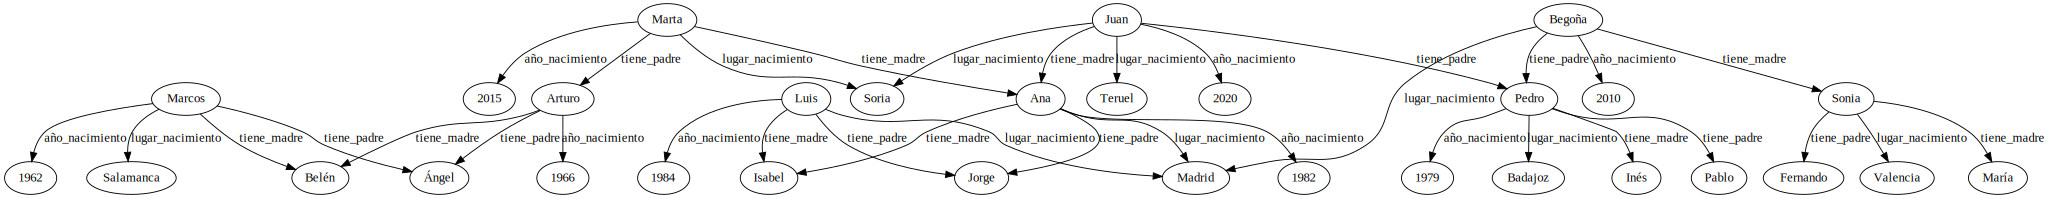

In [28]:
# Se convierte el grafo networkx a un objeto A de pygraphviz que contiene el grafo .dot es A.string(g). 
# En este ejemplo, se renderiza este .dot usando el paquete graphviz.
visualiza_grafo_graphviz(grafo)

In [ ]:
# Se utiliza el paquete pyvis
# Permite ampliación y permite arrastre de nodos
visualiza_grafo_pyvis(grafo,'grafo.html')

# Análisis del grafo
En la [referencia de NetworkX](https://networkx.org/documentation/stable/reference/index.html) además de las funciones básicas descriptivas en [Functions](https://networkx.org/documentation/stable/reference/functions.html), se encuentran algoritmos de cálculos más avanzados en [Algorithms](https://networkx.org/documentation/stable/reference/algorithms/index.html) y [Linear Algebra](https://networkx.org/documentation/stable/reference/linalg.html).

En este ejemplo, se procede a detectar:
+ La lista de nodos con mayor grado (grado_entrada + grado_salida)
+ Los nodos predecesores y sucesores de todos ellos
+ Y se acota el subgrafo que tiene todos esos nodos y mantiene todas las aristas entre ellos

In [12]:
nodos_max = nodos_grado_max(grafo)
predecesores = predecesores_nodos(grafo, nodos_max)
sucesores = sucesores_nodos(grafo, nodos_max)

print(f'Nodos con mayor grado: {nodos_max}')
print(f'Precedidos en el digrafo por {predecesores}')
print(f'Sucedidos en el digrafo por {sucesores}')

Nodos con mayor grado: ['Pedro', 'Ana']
Precedidos en el digrafo por ['Begoña', 'Juan', 'Marta', 'Juan']
Sucedidos en el digrafo por ['1979', 'Badajoz', 'Inés', 'Pablo', '1982', 'Madrid', 'Isabel', 'Jorge']


In [13]:
# Subgrafo producido por nodos con grado máximo, junto a predecesores y sucesores
subgrafo_nodos_max = subgrafo_nodos(grafo,nodos_max)
subgrafo_nodos_max.edges()

OutEdgeView([('Pedro', '1979'), ('Pedro', 'Badajoz'), ('Pedro', 'Inés'), ('Pedro', 'Pablo'), ('Juan', 'Ana'), ('Juan', 'Pedro'), ('Marta', 'Ana'), ('Ana', '1982'), ('Ana', 'Madrid'), ('Ana', 'Isabel'), ('Ana', 'Jorge'), ('Begoña', 'Madrid'), ('Begoña', 'Pedro')])

In [ ]:
visualiza_grafo_graphviz(subgrafo_nodos_max)

# Referencias

**Cuadernos Colab**. Si se ejecutan consultas en Google del tipo `término(s) site:colab.research.google.com` con `término`como _'networkx'_ o _'social network'_, se pueden encontrar otros cuadernos ejecutables relacionados.
+ [tutorial_networkx.ipynb](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjelb7qvdn8AhUDgP0HHUSKCbIQFnoECA8QAQ&url=https%3A%2F%2Fcolab.research.google.com%2Fdrive%2F1m4OKhgu9InS4RL-foL8NFdj16NNriJ3H&usg=AOvVaw03i9_MTALR58Gz4hiX8Moy)
+ [networkx.ipynb](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjelb7qvdn8AhUDgP0HHUSKCbIQFnoECB4QAQ&url=https%3A%2F%2Fcolab.research.google.com%2Fgithub%2Fcaam37830%2Fbook%2Fblob%2Fmaster%2F05_graphs%2Fnetworkx.ipynb&usg=AOvVaw2cPctpkulG52Y9l7opZacK)
+ [comparativeAnalysis.ipynb](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiin4WbwNn8AhXCi_0HHTu_AbQQFnoECBwQAQ&url=https%3A%2F%2Fcolab.research.google.com%2Fgithub%2FZhihaoDC%2FTFG%2Fblob%2Fmain%2Fsource%2FcomparativeAnalysis.ipynb&usg=AOvVaw2zcM4C1CKcCnkuWfoebWMZ)

**Datasets de ejemplo en Networkx**. Hay conjuntos de datos citados en la referencia de Networkx para experimentar. Entre otros, [Words/Ladder Graph](https://networkx.org/documentation/stable/auto_examples/graph/plot_words.html), [Karate club](https://networkx.org/documentation/stable/auto_examples/graph/plot_karate_club.html), [Football](https://networkx.org/documentation/stable/auto_examples/graph/plot_football.html), [Les Miserables](https://networkx.org/documentation/stable/reference/generated/networkx.generators.social.les_miserables_graph.html), [Florentine families](https://networkx.org/documentation/stable/reference/generated/networkx.generators.social.florentine_families_graph.html) o [Southern families](https://networkx.org/documentation/stable/reference/generated/networkx.generators.social.davis_southern_women_graph.html).